In [6]:
import sys
import os 
from pathlib import Path

import pickle 
import numpy as np
import pandas as pd
sys.path.insert(0,str('/Users/ines/research/Lingpred'))
sys.path.insert(0,str(Path().absolute()/"Lingpred"))
import lingpred_new
from lingpred_new.encoding_analysis import self_predictability
    
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt
sns.set_theme()

In [7]:
#dataset = 'Armani'
#dataset = 'Gwilliams'
dataset = 'Goldstein'

if dataset == 'Goldstein':
    data_path    = '/audio/{}/'.format(dataset)
    results_path = data_path
data_path    = '/project/3018059.03/Lingpred/data/{}/self_predictability/'.format(dataset)
results_path = '/project/3018059.03/Lingpred/results/{}/self_predictability/'.format(dataset)

In [ ]:

# load dataframe with the surprisal & prediction values:
path = '/project/3018059.03/Lingpred/data/{}/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl'.format(dataset)
df   = pickle.load(open(path, 'rb'))
        
# make masks for correct and incorrect top-5 prediction
is_top_5      = df.is_Top_5.to_numpy()
is_not_top_5  = np.array([not x for x in is_top_5])

# make masks for correct and incorrect top-5 prediction
is_top_1      = df.is_Top_1.to_numpy()
is_not_top_1  = np.array([not x for x in is_top_1])

In [ ]:
# get dataframe to make the bigram mask:
df_words_all = pd.DataFrame()

for session in np.arange(1, 11):
    df_words = lingpred_new.io.get_words_onsets_offsets(None, 
                                                    dataset=dataset, 
                                                    subject=1, 
                                                    session=session, 
                                                    run=1)
    df_words_all = df_words_all.append(df_words)

bigram_mask = lingpred_new.utils.get_bigram_mask(df_words_all)

In [ ]:
if dataset== 'Armani':
    file_name  = 'X_y_matrices_Glove_GPT_arbitrary_session_1.pkl'
if dataset== 'Gwilliams':
    file_name  = 'X_y_matrices_GPT_Glove_arbitrary.pkl'
filepath = data_path + file_name
data     = pickle.load(open(filepath, 'rb'))
data.keys()

In [ ]:
bigram_mask_first_session = [x for x in bigram_mask if x < 8622]
len(bigram_mask_first_session)

In [ ]:
X = data['X_Glove']
y = data['y_Glove']
selfpred_GloVe_no_bigrams = self_predictability(X = X[bigram_mask_first_session],
                                                y = np.swapaxes(y[bigram_mask_first_session], 0, 1))

X = data['X_GPT']
y = data['y_GPT']
selfpred_GPT_no_bigrams = self_predictability(X = X[bigram_mask_first_session],
                                                y = np.swapaxes(y[bigram_mask_first_session], 0, 1))

X = data['X_arbitrary']
y = data['y_arbitrary']
selfpred_arbitrary_no_bigrams = self_predictability(X = X[bigram_mask_first_session],
                                                    y = np.swapaxes(y[bigram_mask_first_session], 0, 1))


# and save:
filename = 'bigrams_removed_Glove_GPT_Arbitrary_session_1.pkl'
filepath = results_path + filename

values = [selfpred_GloVe_no_bigrams, selfpred_GPT_no_bigrams, selfpred_arbitrary_no_bigrams]
keys   = ['corr_GloVe', 'corr_GPT', 'corr_Arbitrary']
results= dict(zip(keys, values))

f = open(filepath,"wb")
pickle.dump(results,f)
f.close()

## Load / Make vectors for Encoding

In [ ]:
# Let's get X matrices for arbitrary vectors:

from lingpred_new.utils import get_words_onsets_offsets
from lingpred_new.encoding_analysis import make_arbitrary_static_vectors, regress_out_one

words_df            = get_words_onsets_offsets(dataset)
X_arbitrary_vectors = make_arbitrary_static_vectors(words_df, dim=300)

X_arbitrary_residualised = regress_out_one(X_arbitrary_vectors)

X_arbitrary_vectors.shape, X_arbitrary_residualised.shape

((5136, 300), (5135, 300))

In [ ]:
import spacy

nlp     = spacy.load('en_core_web_lg')
X_Glove = np.vstack([nlp(word).vector for word in words_df.word]) # np array of shape (nr_words, 300)
#X_Glove = np.array(X_Glove.get()) # transform from cupy to numpy array for stacking later on 
X_Glove_residualised = regress_out_one(X_Glove)
X_Glove.shape, X_Glove_residualised.shape

((5136, 300), (5135, 300))

## Get the indices to make the y matrix

In [12]:
# load the indices:
with open('/Users/ines/research/Lingpred/audio/Goldstein/indices_all_tasks.pkl', 'rb') as f:
    indices = pickle.load(f)

indices.shape

(5136, 157)

In [30]:
def make_y_matrix_for_selfpred(X, indices, acoustic_model=False):
    
    # initialise y 
    y = np.empty(shape=(indices.shape[0], indices.shape[1], X.shape[1], )) # n_words, n_timepoints, dim   
    
    for word_index in range(indices.shape[0]):
        for nr, time_index in enumerate(indices[word_index]):
            y[word_index][nr] = X[time_index]
    return y

y_arbitrary = make_y_matrix_for_selfpred(indices=indices, X=X_arbitrary_vectors)
y_Glove     = make_y_matrix_for_selfpred(indices=indices, X=X_Glove)

In [31]:
y_arbitrary.shape, y_Glove.shape

((5136, 157, 300), (5136, 157, 300))

In [32]:
selfpred_arbitrary = self_predictability(X=X_arbitrary_vectors, y=np.swapaxes(np.swapaxes(y_arbitrary, 0, 2), 1, 2))
selfpred_Glove = self_predictability(X=X_Glove, y=np.swapaxes(np.swapaxes(y_Glove, 0, 2), 1, 2))

# for residualised we drop the first 'epoch' from y:
selfpred_arbitrary_residualised = self_predictability(X=X_arbitrary_residualised, 
                                                      y=np.swapaxes(np.swapaxes(y_arbitrary[1:], 0, 2), 1, 2))
selfpred_Glove_residualised = self_predictability(X=X_Glove_residualised, 
                                                      y=np.swapaxes(np.swapaxes(y_Glove[1:], 0, 2), 1, 2))

We are now in the regression, and y has shape:
(300, 5136, 157)
We are now in the regression, and y has shape:
(300, 5136, 157)
We are now in the regression, and y has shape:
(300, 5135, 157)
We are now in the regression, and y has shape:
(300, 5135, 157)


In [38]:
import h5py

with h5py.File('/Users/ines/research/Lingpred/Goldstein_gpt_features/features.hdf5', 'r') as f:
    print(list(f.keys()))
    X_GPT = f['layer-8'][:]

['layer-0', 'layer-1', 'layer-10', 'layer-11', 'layer-12', 'layer-13', 'layer-14', 'layer-15', 'layer-16', 'layer-17', 'layer-18', 'layer-19', 'layer-2', 'layer-20', 'layer-21', 'layer-22', 'layer-23', 'layer-24', 'layer-25', 'layer-26', 'layer-27', 'layer-28', 'layer-29', 'layer-3', 'layer-30', 'layer-31', 'layer-32', 'layer-33', 'layer-34', 'layer-35', 'layer-36', 'layer-37', 'layer-38', 'layer-39', 'layer-4', 'layer-40', 'layer-41', 'layer-42', 'layer-43', 'layer-44', 'layer-45', 'layer-46', 'layer-47', 'layer-48', 'layer-5', 'layer-6', 'layer-7', 'layer-8', 'layer-9']


In [39]:
X_GPT.shape

(5491, 1600)

In [44]:
gpt_dataframe = pd.read_csv('/Users/ines/research/Lingpred/Goldstein_gpt_features/transcript_data_gpt.txt', 
                            sep='\t',
                            index_col='Unnamed: 0')
gpt_dataframe

,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,Ä Act,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,Ä one,530,92,0.000342,352,3.732053
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ä monkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,Ä in,287,15,0.004237,0,4.444838
...,...,...,...,...,...,...,...,...,...,...
5486,5132,to,1798.666,1798.746,Ä to,284,0,0.202626,284,3.946364
5487,5133,court,1798.786,1799.006,Ä court,2184,99,0.000510,257,3.669363
5488,5134,over,1799.046,1799.226,Ä over,625,4,0.062957,284,3.113599
5489,5135,it.,1799.327,1799.367,Ä it,340,5,0.013904,257,3.032331


In [45]:
mask            = gpt_dataframe["word_idx"] != gpt_dataframe["word_idx"].shift(-1)
df_filtered     = gpt_dataframe[mask]
mask_last_token = df_filtered.index
len(mask_last_token)

5136

In [ ]:
X_GPT              = X_GPT[mask_last_token]
X_GPT_residualised = regress_out_one(X_GPT)
X_GPT.shape, X_GPT_residualised.shape

((5136, 1600), (5135, 1600))

In [51]:
y_GPT = make_y_matrix_for_selfpred(indices=indices, X=X_GPT)
y_GPT.shape

(5136, 157, 1600)

In [52]:

selfpred_GPT = self_predictability(X=X_GPT, y=np.swapaxes(np.swapaxes(y_GPT, 0, 2), 1, 2))

# for residualised we drop the first 'epoch' from y:
selfpred_GPT_residualised = self_predictability(X=X_GPT_residualised, 
                                                y=np.swapaxes(np.swapaxes(y_GPT[1:], 0, 2), 1, 2))

We are now in the regression, and y has shape:
(1600, 5136, 157)
We are now in the regression, and y has shape:
(1600, 5135, 157)


In [54]:
# save the GTP features:
values   = [selfpred_GPT, selfpred_GPT_residualised]
keys     = ['selfpred_GPT_layer_8', 'selfpred_GPT_residualised_layer_8']
results  = dict(zip(keys, values))
filepath =   '/Users/ines/research/Lingpred/audio/Goldstein/selfpred_GPT_original_and_residualised_layer_8.pkl'

f = open(filepath,"wb")
pickle.dump(results,f)
f.close()

In [55]:
# save the GTP features:
values   = [X_GPT, X_GPT_residualised]
keys     = ['X_GPT_layer_8', 'X_GPT_residualised_layer_8']
results  = dict(zip(keys, values))
filepath =  '/Users/ines/research/Lingpred/audio/Goldstein//X_GPT_original_and_residualised_layer_8.pkl'

f = open(filepath,"wb")
pickle.dump(results,f)
f.close()

## Plots

Text(0.5, 1.0, 'Goldstein:Self-predictability')

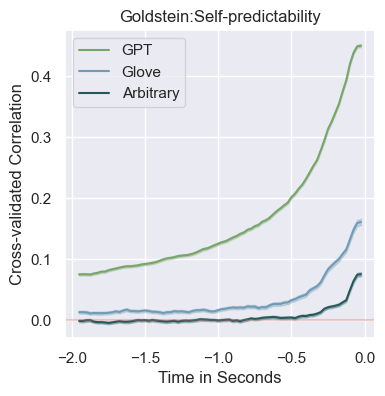

In [56]:
from lingpred_new.plotting import times_100, colours, lowerCI, upperCI

# get model names
models = ['GPT', 'Glove', 'Arbitrary']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, corr in enumerate([selfpred_GPT, selfpred_Glove, selfpred_arbitrary]):
    ax1.plot(times_100[:78], corr.mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(corr)[:78], upperCI(corr)[:78], color=colours[models[i]], alpha=0.3)

ax1.legend()
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+':' + 'Self-predictability')

Text(0.5, 1.0, 'Goldstein: Residualised Self-predictability')

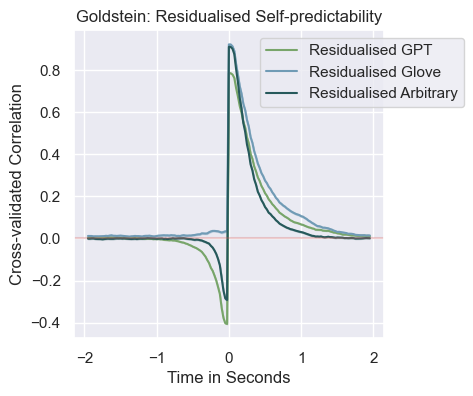

In [64]:
# get model names
models = ['GPT', 'Glove', 'Arbitrary']
labels = ['Residualised ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, corr in enumerate([selfpred_GPT_residualised, selfpred_Glove_residualised, selfpred_arbitrary_residualised]):
    ax1.plot(times_100, corr.mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(corr), upperCI(corr), color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.6,0.75))
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + 'Residualised Self-predictability')